In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
df = pd.read_csv('dataset.csv')

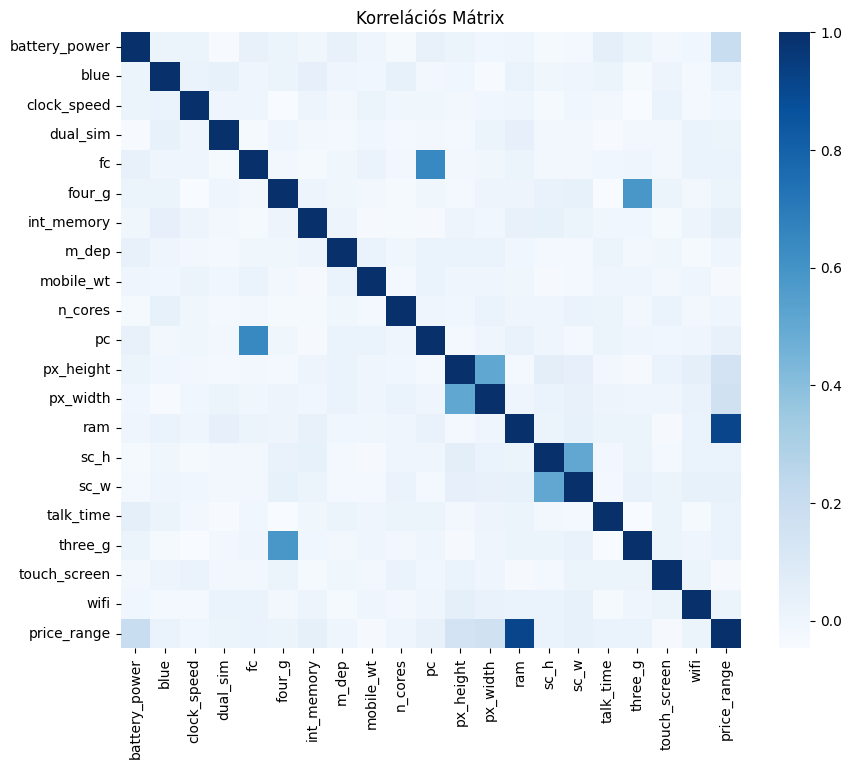

In [3]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=False, cmap='Blues')
plt.title('Korrelációs Mátrix')
plt.show()

In [4]:
q_low = df['px_height'].quantile(0.01)
q_high = df['px_height'].quantile(0.99)
df_stat_clean = df[(df['px_height'] > q_low) & (df['px_height'] < q_high)].copy()

In [5]:
df_stat_clean = df_stat_clean.dropna()

In [6]:
df_stat_clean['px_area'] = df_stat_clean['px_width'] * df_stat_clean['px_height']

In [7]:
x_temp = df_stat_clean.drop(columns=['price_range'])
y_temp = df_stat_clean['price_range'].values

In [8]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x_temp)

In [9]:
dbscan = DBSCAN(eps=100.0, min_samples=5)
outlier_labels = dbscan.fit_predict(x_scaled)

In [10]:
mask = outlier_labels != -1
x_final_pre = x_scaled[mask]
y_final = y_temp[mask]

In [11]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(x_final_pre)

In [12]:
x_final = pd.DataFrame(x_final_pre, columns=x_temp.columns)
x_final['Cluster_Feature'] = clusters

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    x_final, y_final, test_size=0.2, random_state=42
)

In [14]:
model = Sequential()

model.add(Dense(64, activation='relu', input_shape=[x_train.shape[1]]))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))

model.add(Dense(4, activation='softmax'))

C:\Users\bence\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

In [17]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2904 - loss: 1.3559 - val_accuracy: 0.4184 - val_loss: 1.2331
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6675 - loss: 0.8256 - val_accuracy: 0.7959 - val_loss: 0.4844
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8666 - loss: 0.3377 - val_accuracy: 0.8622 - val_loss: 0.3197
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9126 - loss: 0.2059 - val_accuracy: 0.8648 - val_loss: 0.3013
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9253 - loss: 0.1648 - val_accuracy: 0.8750 - val_loss: 0.2743
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9502 - loss: 0.1297 - val_accuracy: 0.8827 - val_loss: 0.2826
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9572 - loss: 0.1068 - val_accuracy: 0.8954 - val_loss: 0.2656
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9783 - loss: 0.0704 - val_accuracy: 0.8903 - v

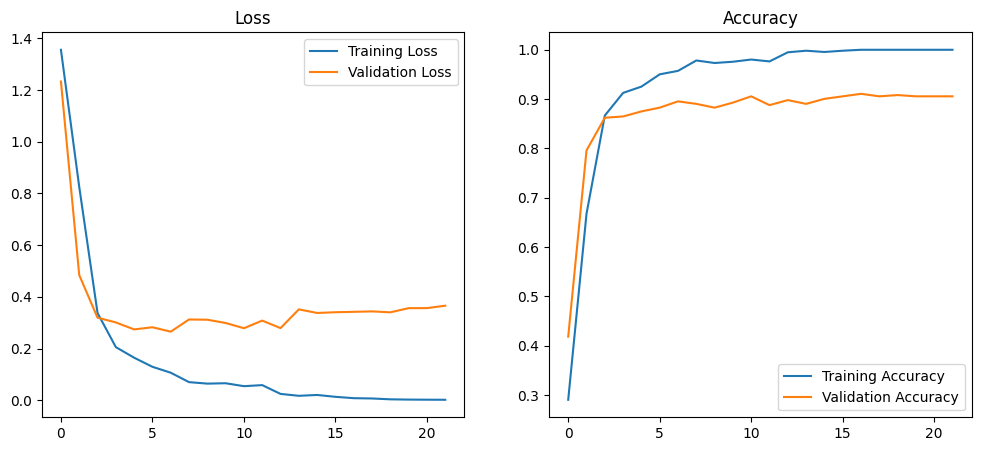

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [19]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"{test_acc:f}")

0.895408


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


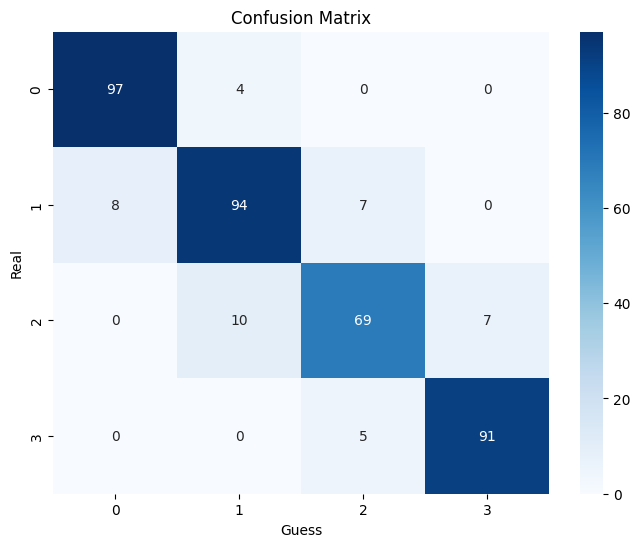

In [20]:
y_pred = np.argmax(model.predict(x_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Guess')
plt.ylabel('Real')
plt.show()